In [2]:
%cd ..

W:\gconvnet-copy


In [3]:
import sys
import random

import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import matplotlib
from tensorflow.keras import layers
from gconvnet import GConv2D, GMaxPool,ForgetAction,RememberAction
import gconvnet.groups as groups

In [4]:
print('Tensorflow version: {}'.format(tf.__version__))
print('Keras      version: {}'.format(tf.keras.__version__))
print('Numpy version:      {}'.format(np.__version__))
print('Matplotlib version: {}'.format(matplotlib.__version__))
print('Python version:     {}'.format(sys.version))

Tensorflow version: 2.1.0
Keras      version: 2.2.4-tf
Numpy version:      1.18.1
Matplotlib version: 3.1.3
Python version:     3.7.7 (default, Apr 15 2020, 05:09:04) [MSC v.1916 64 bit (AMD64)]


We now load the MNIST data. It is organized as follows:
* Each samples is represented as 785 scalars. The first 24*24=784 are the pixel values. The last is the label.
* mnist_train.amat contains 12,000 samples. The first 10,000 are training samples, the last 2000 are validation samples.
* mnist_test.amat contains 50,000 test samples.

In [4]:
train_n = 10000 
val_n = 2000
test_n = 50000
sample_width = 28
sample_height = 28

In [5]:
raw_train_val_data = np.loadtxt('gconvnet/examples/mnist_all_rotation_normalized_float_train_valid.amat')
raw_test_data = np.loadtxt('gconvnet/examples/mnist_all_rotation_normalized_float_test.amat')

In [6]:
assert raw_train_val_data.shape[0] == train_n + val_n, \
       'mnist_train.amat had unexpected number of samples'
assert raw_test_data.shape[0] == test_n, \
       'mnist_test.amat had unexpected number of samples'

assert raw_train_val_data.shape[1] == sample_width*sample_height + 1, \
    "mnist_train.amat samples have wrong size, expected {0} got {1}".format(
           sample_width*sample_height+1, raw_train_val_data.shape[1])
assert raw_test_data.shape[1] == sample_width*sample_height + 1, \
    "mnist_test.amat samples have wrong size, expected {0} got {1}".format(
           sample_width*sample_height+1, raw_test_data.shape[1])

train_x = raw_train_val_data[:train_n,:-1].reshape(train_n,sample_width,sample_height,1,1)
train_y = raw_train_val_data[:train_n,-1]

val_x = raw_train_val_data[train_n:,:-1].reshape(val_n,sample_width,sample_height,1,1)
val_y = raw_train_val_data[train_n:,-1]

test_x = raw_test_data[:,:-1].reshape(test_n,sample_width,sample_height,1,1)
test_y = raw_test_data[:,-1]

train_data = {
    'x' : train_x,
    'y' : train_y,
    'y_cat' : tf.keras.utils.to_categorical(train_y,10),
    'name' : 'train',
    'n' : train_n}
test_data = {
    'x' : test_x,
    'y' : test_y,
    'y_cat' : tf.keras.utils.to_categorical(test_y,10),
    'name' : 'test',
    'n' : test_n}
val_data = {
    'x' : val_x,
    'y' : val_y,
    'y_cat' : tf.keras.utils.to_categorical(val_y,10),
    'name' : 'validation',
    'n' : val_n}

# Inspection

Train dataset sample #6956 with label: 6.0


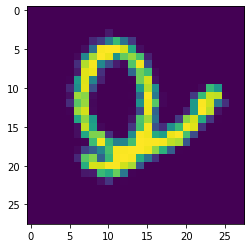

In [7]:
dataset_to_inspect = train_data
example_idx = -1 # index of sample to inspect. -1 for random.

if example_idx == -1:
    example_idx = random.randint(0,dataset_to_inspect['n']-1)

assert (example_idx >= 0 and example_idx < dataset_to_inspect['n']-1), \
    'Example index out of bounds'

example_x = dataset_to_inspect['x'][example_idx].reshape(sample_width,sample_height)
example_y = dataset_to_inspect['y'][example_idx]

plt.imshow(example_x)

print('{0} dataset sample #{1} with label: {2}'.format(
    dataset_to_inspect['name'].capitalize(), example_idx, example_y))

# Model

In [20]:
d4_full_subgroup= groups.create_inclusion(groups.d4, list(range(8)))

p4cnn_rp = keras.Sequential()
p4cnn_rp.add(GConv2D(20,
                     kernel_size=(3,3),
                     input_shape=(28,28,1,1),
                     G = 'd4',
                     G_action = 'd4',
                     activation='relu',
                     use_bias = False,
                     name='GConv1'))
p4cnn_rp.add(layers.BatchNormalization())
p4cnn_rp.add(GMaxPool(d4_full_subgroup))

p4cnn_rp.add(GConv2D(20,
                     kernel_size=(3,3),
                     G = 'd4',
                     G_action = 'd4',
                     activation='relu',
                     use_bias = False,
                     name='GConv2'))
p4cnn_rp.add(layers.BatchNormalization())
p4cnn_rp.add(GMaxPool(d4_full_subgroup))

p4cnn_rp.add(ForgetAction())
p4cnn_rp.add(layers.MaxPool2D())
p4cnn_rp.add(RememberAction('trivial'))



p4cnn_rp.add(GConv2D(20,
                     kernel_size=(3,3),
                     G = 'd4',
                     G_action = 'd4',
                     activation='relu',
                     use_bias = False,
                     name='GConv3'))
p4cnn_rp.add(layers.BatchNormalization())
p4cnn_rp.add(GMaxPool(d4_full_subgroup))


p4cnn_rp.add(GConv2D(20,
                     kernel_size=(3,3),
                     G = 'd4',
                     G_action = 'd4',
                     activation='relu',
                     use_bias = False,
                     name='GConv4'))
p4cnn_rp.add(layers.BatchNormalization())
p4cnn_rp.add(GMaxPool(d4_full_subgroup))


p4cnn_rp.add(GConv2D(20,
                     kernel_size=(3,3),
                     G = 'd4',
                     G_action = 'd4',
                     activation='relu',
                     use_bias = False,
                     name='GConv5'))
p4cnn_rp.add(layers.BatchNormalization())
p4cnn_rp.add(GMaxPool(d4_full_subgroup))


p4cnn_rp.add(GConv2D(20,
                     kernel_size=(3,3),
                     G = 'd4',
                     G_action = 'd4',
                     activation='relu',
                     use_bias = False,
                     name='GConv6'))
p4cnn_rp.add(layers.BatchNormalization())
p4cnn_rp.add(GMaxPool(d4_full_subgroup))


p4cnn_rp.add(GConv2D(10,
                     kernel_size=(3,3),
                     G = 'd4',
                     G_action = 'd4',
                     activation='relu',
                     use_bias = False,
                     name='GConv7'))
p4cnn_rp.add(layers.BatchNormalization())
p4cnn_rp.add(GMaxPool(d4_full_subgroup))


p4cnn_rp.add(layers.Flatten())
p4cnn_rp.add(layers.Dense(10, activation='softmax'))

In [9]:
p4cnn = keras.Sequential()
p4cnn.add(GConv2D(10,
                  kernel_size=(3,3),
                  input_shape=(28,28,1,1),
                  G = 'd4',
                  G_action = 'd4',
                  activation='relu',
                  use_bias = False,
                  name='GConv1'))
p4cnn.add(layers.BatchNormalization())
p4cnn.add(GConv2D(10,
                  kernel_size=(3,3),
                  G = 'd4',
                  G_action = 'd4',
                  activation='relu',
                  use_bias = False,
                  name='GConv2'))
p4cnn.add(layers.BatchNormalization())
p4cnn.add(ForgetAction())
p4cnn.add(layers.MaxPool2D())
p4cnn.add(RememberAction('d4'))


p4cnn.add(GConv2D(10,
                  kernel_size=(3,3),
                  G = 'd4',
                  G_action = 'd4',
                  activation='relu',
                  use_bias = False,
                  name='GConv3'))
p4cnn.add(layers.BatchNormalization())


p4cnn.add(GConv2D(10,
                  kernel_size=(3,3),
                  G = 'd4',
                  G_action = 'd4',
                  activation='relu',
                  use_bias = False,
                  name='GConv4'))
p4cnn.add(layers.BatchNormalization())


p4cnn.add(GConv2D(10,
                  kernel_size=(3,3),
                  G = 'd4',
                  G_action = 'd4',
                  activation='relu',
                  use_bias = False,
                  name='GConv5'))
p4cnn.add(layers.BatchNormalization())


p4cnn.add(GConv2D(10,
                  kernel_size=(3,3),
                  G = 'd4',
                  G_action = 'd4',
                  activation='relu',
                  use_bias = False,
                  name='GConv6'))
p4cnn.add(layers.BatchNormalization())

p4cnn.add(GConv2D(10,
                  kernel_size=(3,3),
                  G = 'd4',
                  G_action = 'd4',
                  activation='relu',
                  use_bias = False,
                  name='GConv7'))

p4cnn.add(layers.Flatten())
p4cnn.add(layers.Dense(10, activation='softmax'))

In [10]:
p4cnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
GConv1 (GConv2D)             (None, 26, 26, 8, 10)     90        
_________________________________________________________________
batch_normalization_7 (Batch (None, 26, 26, 8, 10)     40        
_________________________________________________________________
GConv2 (GConv2D)             (None, 24, 24, 8, 10)     7200      
_________________________________________________________________
batch_normalization_8 (Batch (None, 24, 24, 8, 10)     40        
_________________________________________________________________
forget_action_1 (ForgetActio (None, 24, 24, 80)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 80)        0         
_________________________________________________________________
remember_action_1 (RememberA (None, 12, 12, 8, 10)    

In [21]:
p4cnn.compile(
    optimizer=tf.train.AdamOptimizer(),
    loss='categorical_crossentropy',
    metrics=['accuracy'])
p4cnn_rp.compile(
    optimizer=tf.train.AdamOptimizer(),
    loss='categorical_crossentropy',
    metrics=['accuracy'])

In [13]:
p4cnn.fit(
    train_data['x'],
    train_data['y_cat'],
    batch_size=128,
    epochs=25)

Epoch 1/25
10000/10000 [==============================] - 5s 477us/sample - loss: 1.2226 - acc: 0.5887
Epoch 2/25
10000/10000 [==============================] - 3s 325us/sample - loss: 0.4319 - acc: 0.8656
Epoch 3/25
10000/10000 [==============================] - 3s 326us/sample - loss: 0.2893 - acc: 0.9089
Epoch 4/25
10000/10000 [==============================] - 3s 331us/sample - loss: 0.1992 - acc: 0.9360
Epoch 5/25
10000/10000 [==============================] - 3s 326us/sample - loss: 0.1675 - acc: 0.9479
Epoch 6/25
10000/10000 [==============================] - 3s 332us/sample - loss: 0.1466 - acc: 0.9502
Epoch 7/25
10000/10000 [==============================] - 3s 326us/sample - loss: 0.1115 - acc: 0.9619
Epoch 8/25
10000/10000 [==============================] - 3s 330us/sample - loss: 0.1005 - acc: 0.9678
Epoch 9/25
10000/10000 [==============================] - 3s 332us/sample - loss: 0.0894 - acc: 0.9692
Epoch 10/25
10000/10000 [==============================] - 3s 329us/sampl

In [14]:
p4cnn.evaluate(val_data['x'],val_data['y_cat'])

2000/2000 [==============================] - 0s 231us/sample - loss: 0.2636 - acc: 0.9435


[0.26358294396847487, 0.9435]

In [ ]:
p4cnn_rp.fit(
    train_data['x'],
    train_data['y_cat'],
    epochs=25)

Epoch 1/25
10000/10000 [==============================] - 8s 847us/sample - loss: 1.8055 - acc: 0.3673
Epoch 2/25
10000/10000 [==============================] - 8s 762us/sample - loss: 0.8501 - acc: 0.7328
Epoch 3/25
10000/10000 [==============================] - 8s 764us/sample - loss: 0.4502 - acc: 0.8613
Epoch 4/25
10000/10000 [==============================] - 8s 767us/sample - loss: 0.3263 - acc: 0.9001
Epoch 5/25
10000/10000 [==============================] - 8s 776us/sample - loss: 0.2650 - acc: 0.9215
Epoch 6/25
10000/10000 [==============================] - 8s 791us/sample - loss: 0.2209 - acc: 0.9294
Epoch 7/25
10000/10000 [==============================] - 8s 770us/sample - loss: 0.1960 - acc: 0.9384
Epoch 8/25
10000/10000 [==============================] - 8s 756us/sample - loss: 0.1743 - acc: 0.9434
Epoch 9/25
10000/10000 [==============================] - 8s 758us/sample - loss: 0.1558 - acc: 0.9490
Epoch 10/25
10000/10000 [==============================] - 8s 759us/sampl

In [17]:
p4cnn_rp.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
GConv1 (GConv2D)             (None, 26, 26, 8, 20)     180       
_________________________________________________________________
batch_normalization (BatchNo (None, 26, 26, 8, 20)     80        
_________________________________________________________________
g_max_pool (GMaxPool)        (None, 26, 26, 1, 20)     0         
_________________________________________________________________
GConv2 (GConv2D)             (None, 24, 24, 8, 20)     3600      
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 24, 8, 20)     80        
_________________________________________________________________
g_max_pool_1 (GMaxPool)      (None, 24, 24, 1, 20)     0         
_________________________________________________________________
forget_action (ForgetAction) (None, 24, 24, 20)        0